<a href="https://colab.research.google.com/github/jeudicode/MCC-AP/blob/master/tareas/tarea1/Tarea1_Diego_Isla_Lopez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets
import os
from itertools import islice as take
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as vutils
import torchvision.transforms as trans
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url
from torchsummary import summary



# Ejercicio 1: Red de unidades de umbral lineal

**Programa y evalúa una red de neuronas con funciones de activación escalón unitario que aproxime la operación XNOR.**



Definimos nuestras funciones que usaremos para representar la función de evaluación y de representación de neuronas y las capas:

In [ ]:
def escalon(z):
    if z > 0.0:
        return 1.0
    else:
        return 0.0

In [ ]:

def neurona(x, w, b):
  z = np.dot(w.T, x) + b
  a = escalon(z)

  return a

In [ ]:
def multicapa(x, W1, b1, W2, b2):
  escv = np.vectorize(escalon)
  a = escv(np.dot(W1.T, x) + b1)
  return escv(np.dot(W2.T, a) + b2)

Definimos el vector objetivo para la compuerta XNOR de la siguiente manera:

In [ ]:
y_xnor = [1., 0., 0., 1.]

Definimos el vector con las entradas posibles:

In [ ]:
X = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])


Para la estructura de la red, utilizamos una muy similar a la requerida para la compuerta XOR. En este caso, en lugar de usar una neurona que aplique la operación NAND, utilizamos una que aplique la operación NOR, además de una neurona que aplique la operación OR en la última capa. 

Para esto, primero debemos obtener los pesos necesarios para la operación NOR y definir la salida esperada. En este caso, observamos que los pesos necesarios son -1 para ambas entradas con un sesgo de 1

In [ ]:
W1_nor = np.array([-1, -1])
b1_nor = np.array([1])
y_nor = np.array([1.,0.,0.,0.])

In [ ]:
for i in range(X.shape[0]):
  y_hat = neurona(X[i], W1_nor, b1_nor)
  print('{0}\t{1}\t{2}\t{3}'.format(X[i, 0], X[i, 1], y_nor[i], y_hat))

0.0	0.0	1.0	1.0
0.0	1.0	0.0	0.0
1.0	0.0	0.0	0.0
1.0	1.0	0.0	0.0


De este modo, sabemos que los pesos y sesgos para las compuertas necesarias son:

AND: W = [10, 10], b = -15

NOR: W = [-1, -1], b = 1

OR:  W = [10, 10], b = -5


Representamos esto en la estructura de la red:

In [ ]:
W1 = np.array([[10, -1], [10, -1]])
b1 = np.array([-15, 1])

W2 = np.array([[10],[10]])
b2 = np.array([-5])

Se realiza la evaluación:

In [ ]:
for i in range(X.shape[0]):
  y_hat = multicapa(X[i], W1, b1, W2, b2)
  print('{0}\t{1}\t{2}\t{3}'.format(X[i, 0], X[i, 1], y_xnor[i], y_hat[0]))

0.0	0.0	1.0	1.0
0.0	1.0	0.0	0.0
1.0	0.0	0.0	0.0
1.0	1.0	1.0	1.0



# Ejercicio 2: Retropropagación en red densa

**Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo un red densa con dos capas ocultas y la función de pérdida de entropía cruzada binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.**

Definimos nuestras funciones, actualizando la función de feed-forward y la función de retropropagación para trabajar con dos capas ocultas:

In [ ]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

La función de activación seguirá siendo la sigmoide, dada por:

$\sigma(z) = \frac{1}{1+e^-z}$

In [ ]:
def derivada_sigmoide(x):
    return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

Del mismo modo, sabemos que la derivada de esta función es:

$\frac{\partial \sigma(z)}{\partial z} = \sigma(z)(1-\sigma(z))$

La función de errror, ECB, se mantiene igual. Del mismo modo, el cálculo de la exactitud se mantiene sin cambios:

In [ ]:
def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [ ]:
def exactitud(y, y_predicha):
    return (y == y_predicha).mean() * 100

$\texttt{exactitud} = \frac{\texttt{correctos}}{\texttt{total}}$

Al agregar una capa extra, la propagación de las capas queda de la siguiente manera:

\begin{align}
a^{\{1\}} &= x^{\{i\}}\\
z^{\{2\}} &= W^{\{1\}} \cdot a^{\{1\}} + b^{\{1\}}\\
a^{\{2\}} &= \sigma(z^{\{2\}})\\
z^{\{3\}} &= W^{\{2\}} \cdot a^{\{2\}} + b^{\{2\}}\\
a^{\{3\}} &= \sigma(z^{\{3\}})\\
z^{\{4\}} &= W^{\{3\}} \cdot a^{\{3\}} + b^{\{3\}}\\
a^{\{4\}} &= \sigma(z^{\{4\}})\\
\hat y^{\{i\}} &= a^{\{4\}}
\end{align}

De este modo, agregamos los parámentros necesarios en las funciones:

In [ ]:
# en esta funcion agregamos una capa oculta más

def hacia_adelante(x, W1, b1, W2, b2, W3, b3):
    z2 = np.dot(W1.T, x[:, np.newaxis]) + b1
    a2 = sigmoide(z2)
    z3 = np.dot(W2.T, a2) + b2
    a3 = sigmoide(z3)
    z4 = np.dot(W3.T, a3) + b3
  
    y_hat = sigmoide(z4)

    return z2, a2, z3, a3, z4, y_hat

In [ ]:

def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
        
    # Inicialización de las matrices de pesos W y V
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))
    
    W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
    b2 = np.zeros((n_ocultas, 1))

    W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b3 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, a3, z4, y_hat = hacia_adelante(X[j], W1, b1, W2, b2, W3, b3)

            # gradiente de capa de salida
            dz4 = y_hat - y[j]
            dW3 = np.outer(a3, dz4)
            db3 = dz4
            
            # cálculo de gradientes para W2 y b2 por retropropagación
            dz3 = np.dot(W3, dz4) * derivada_sigmoide(z3)
            dW2 = np.outer(a2, dz3)
            db2 = dz3

            # cálculo de gradientes para W1 y b1 por retropropagación
            dz2 = np.dot(W2, dz3) * derivada_sigmoide(z2)
            dW1 = np.outer(X[j], dz2)
            db1 = dz2
            
            ####################################
            # IMPORTANTE 
            # la actualización de los parámetros
            # debe hacerse de forma simultánea
            W3 = W3 - alpha * dW3
            b3 = b3 - alpha * db3
            W2 = W2 - alpha * dW2
            b2 = b2 - alpha * db2
            W1 = W1 - alpha * dW1
            b1 = b1 - alpha * db1

            y_predicha[j] = y_hat
            
        # calcula la pérdida en la época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))

    return W2, W3, perdidas, exactitudes

Retomaremos el ejemplo del ejercicio anterior, entrenando la red para replicar el comportamiento de la compuerta XNOR:

Configuramos los parámetros y llamamos el algoritmo de retropropagación. Para este caso, usamos una tasa de aprendizaje de 0.5, 1000 épocas y 3 neuronas por capa oculta.

In [ ]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

np.random.seed(1)
W2, W3, perdidas, exactitudes = retropropagacion(X, 
                                                 y, 
                                                 alpha = 0.5, 
                                                 n_epocas = 1000,
                                                 n_ocultas = 3)

Epoch 0: Pérdida = 3.380869040951691 Exactitud = 25.0
Epoch 1: Pérdida = 3.2857723837421315 Exactitud = 25.0
Epoch 2: Pérdida = 3.267215172634099 Exactitud = 25.0
Epoch 3: Pérdida = 3.2591416681758494 Exactitud = 25.0
Epoch 4: Pérdida = 3.2527571682000405 Exactitud = 25.0
Epoch 5: Pérdida = 3.2468095566743598 Exactitud = 25.0
Epoch 6: Pérdida = 3.2410927305515314 Exactitud = 25.0
Epoch 7: Pérdida = 3.235562794061976 Exactitud = 25.0
Epoch 8: Pérdida = 3.230205926582393 Exactitud = 25.0
Epoch 9: Pérdida = 3.225015293982879 Exactitud = 25.0
Epoch 10: Pérdida = 3.219986023505334 Exactitud = 25.0
Epoch 11: Pérdida = 3.215113840634692 Exactitud = 25.0
Epoch 12: Pérdida = 3.2103946433348294 Exactitud = 25.0
Epoch 13: Pérdida = 3.205824365373208 Exactitud = 25.0
Epoch 14: Pérdida = 3.201398938641068 Exactitud = 25.0
Epoch 15: Pérdida = 3.197114290548456 Exactitud = 25.0
Epoch 16: Pérdida = 3.1929663533997292 Exactitud = 25.0
Epoch 17: Pérdida = 3.188951077137239 Exactitud = 25.0
Epoch 18: Pér

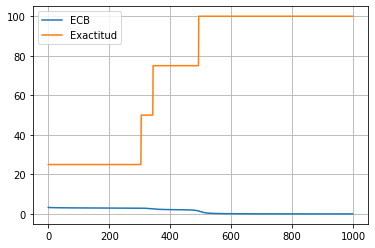

In [ ]:
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

En la gráfica es posible apreciar que el algoritmo es capaz de encontrar la configuración correcta alrededor de la época 500, además de que desde el inicio el valor de pérdida es bajo y logra disminuir gradualmente. 

# 3. Regresión lineal con PyTorch

**Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que considere los dos atributos de entrada.**

Se carga el conjunto de datos de calificaciones:

In [ ]:
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv'
base_dir = '../data/califs/'
filename = 'califs.csv'
filepath = os.path.join(base_dir, 'califs.csv')

download_url(URL, base_dir, filename)

torch.manual_seed(10) # para reproducibilidad


Using downloaded and verified file: ../data/califs/califs.csv


In [ ]:
df = pd.read_csv(filepath, names=['calif anterior','horas de estudio','calificación'])
df.head(5)

,calif anterior,horas de estudio,calificación
0,5.638,8.289,5.136
1,6.744,9.389,5.931
2,5.136,10.060,5.484
3,5.748,10.421,6.524
4,7.136,10.434,6.770


Graficamos tomando en cuenta ambos atributos de entrada:

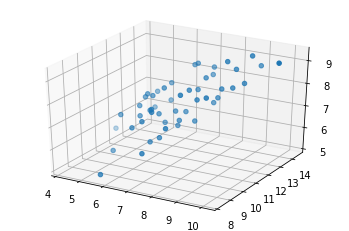

In [ ]:
x_trn = np.array(df.iloc[:,0], dtype="float32")[..., np.newaxis]
y_trn = np.array(df.iloc[:,1], dtype="float32")[..., np.newaxis]
z_trn = np.array(df.iloc[:,2], dtype="float32")[..., np.newaxis]

ax = plt.axes(projection='3d')
ax.scatter3D(x_trn, y_trn, z_trn);


Creamos la clase del dataset tomando en cuenta los dos atributos:

In [ ]:
class CalifDS:
    
    def __init__(self, X, Y, Z):
        self.x = X
        self.y = Y
        self.z = Z

    def __getitem__(self, i):
        X = np.array([self.x[i], self.y[i]]).flatten()
        y = self.z[i]

        return X, y

    def __len__(self):
        return len(self.z)

Probamos el funcionamiento del dataset:

In [ ]:
batch_size = 16
ds = CalifDS(x_trn, y_trn, z_trn)
trn_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

print(ds.__getitem__(0))
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

(array([5.638, 8.289], dtype=float32), array([5.136], dtype=float32))
x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


Utilizaremos las interfaces de alto y medio nivel, tomando en cuenta los dos atributos de entrada:

In [ ]:
model_high = nn.Sequential(
    nn.Linear(2, 1)
)

In [ ]:
class RegLin(nn.Module):
    def __init__(self):
        super(RegLin, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc(x)

model_mid = RegLin()

Verificando:

In [ ]:
print(model_high)
print(model_mid)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
RegLin(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


Verificamos:

In [ ]:
# inferencia con datos sintéticos
x = torch.zeros(1,2)
y_high = model_high(x)
y_mid = model_mid(x)
print(x.dtype, x.shape)
print(y_mid.dtype, y_mid.shape)
print(y_high.dtype, y_high.shape)

torch.float32 torch.Size([1, 2])
torch.float32 torch.Size([1, 1])
torch.float32 torch.Size([1, 1])


Hacemos pruebas con diferentes parámetros:

In [ ]:
batches = [5, 10, 15, 20, 25] # tamaños de batch
l_rates = [1e-3, 0.01, 0.2, 0.5, 0.8, 1] # tasas de aprendizaje
epochs = [2, 5, 10, 50, 100] # números de épocas

high_hist = []
mid_hist = []

# para alto nivel

for batch in batches:
  ds = CalifDS(x_trn, y_trn, z_trn)
  trn_dl = DataLoader(ds, batch_size=batch, shuffle=True)

  for rate in l_rates:
    for epoch in epochs:

      model_high = nn.Sequential(
          nn.Linear(2, 1)
      )

      opt = optim.SGD(model_high.parameters(), lr=rate)

      # historial de pérdida
      loss_hist_high = []

      for _ in range(epoch):
        # entrenamiento de una época
        for x, y_true in trn_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model_high(x)
            # calculamos de pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()
            
            # guardamos historial de pérdida
            loss_hist_high.append(loss.item() * 100)

        high_hist.append(loss_hist_high)

# para nivel medio
for batch in batches:
  ds = CalifDS(x_trn, y_trn, z_trn)
  trn_dl = DataLoader(ds, batch_size=batch, shuffle=True)

  for rate in l_rates:
    for epoch in epochs:
      model_mid = RegLin()
      opt = optim.SGD(model_mid.parameters(), lr=rate)

      # historial de pérdida
      loss_hist_mid = []
      for _ in range(epoch):

        # entrenamiento de una época
        for x, y_true in trn_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model_mid(x)
            # print(y_lgts)
            # calculamos de pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()
            
            # guardamos historial de pérdida
            loss_hist_mid.append(loss.item() * 100)

        mid_hist.append(loss_hist_mid)


Graficamos el desempeño con la interfaz de alto nivel:

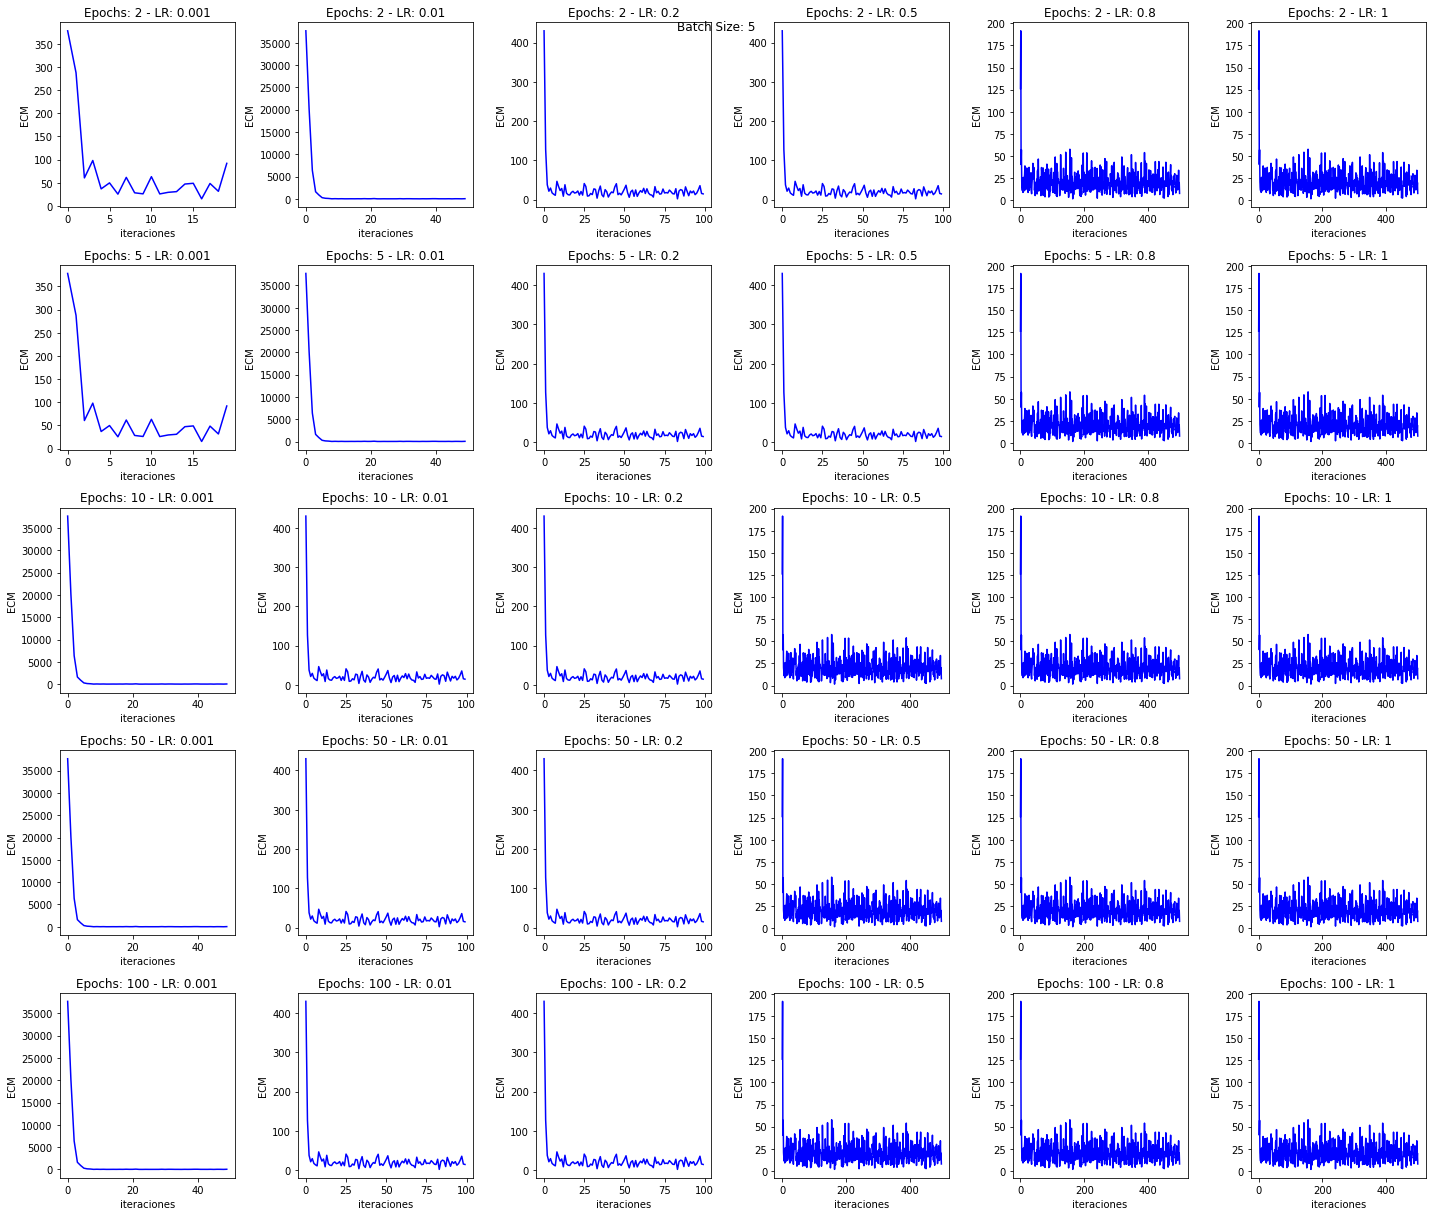

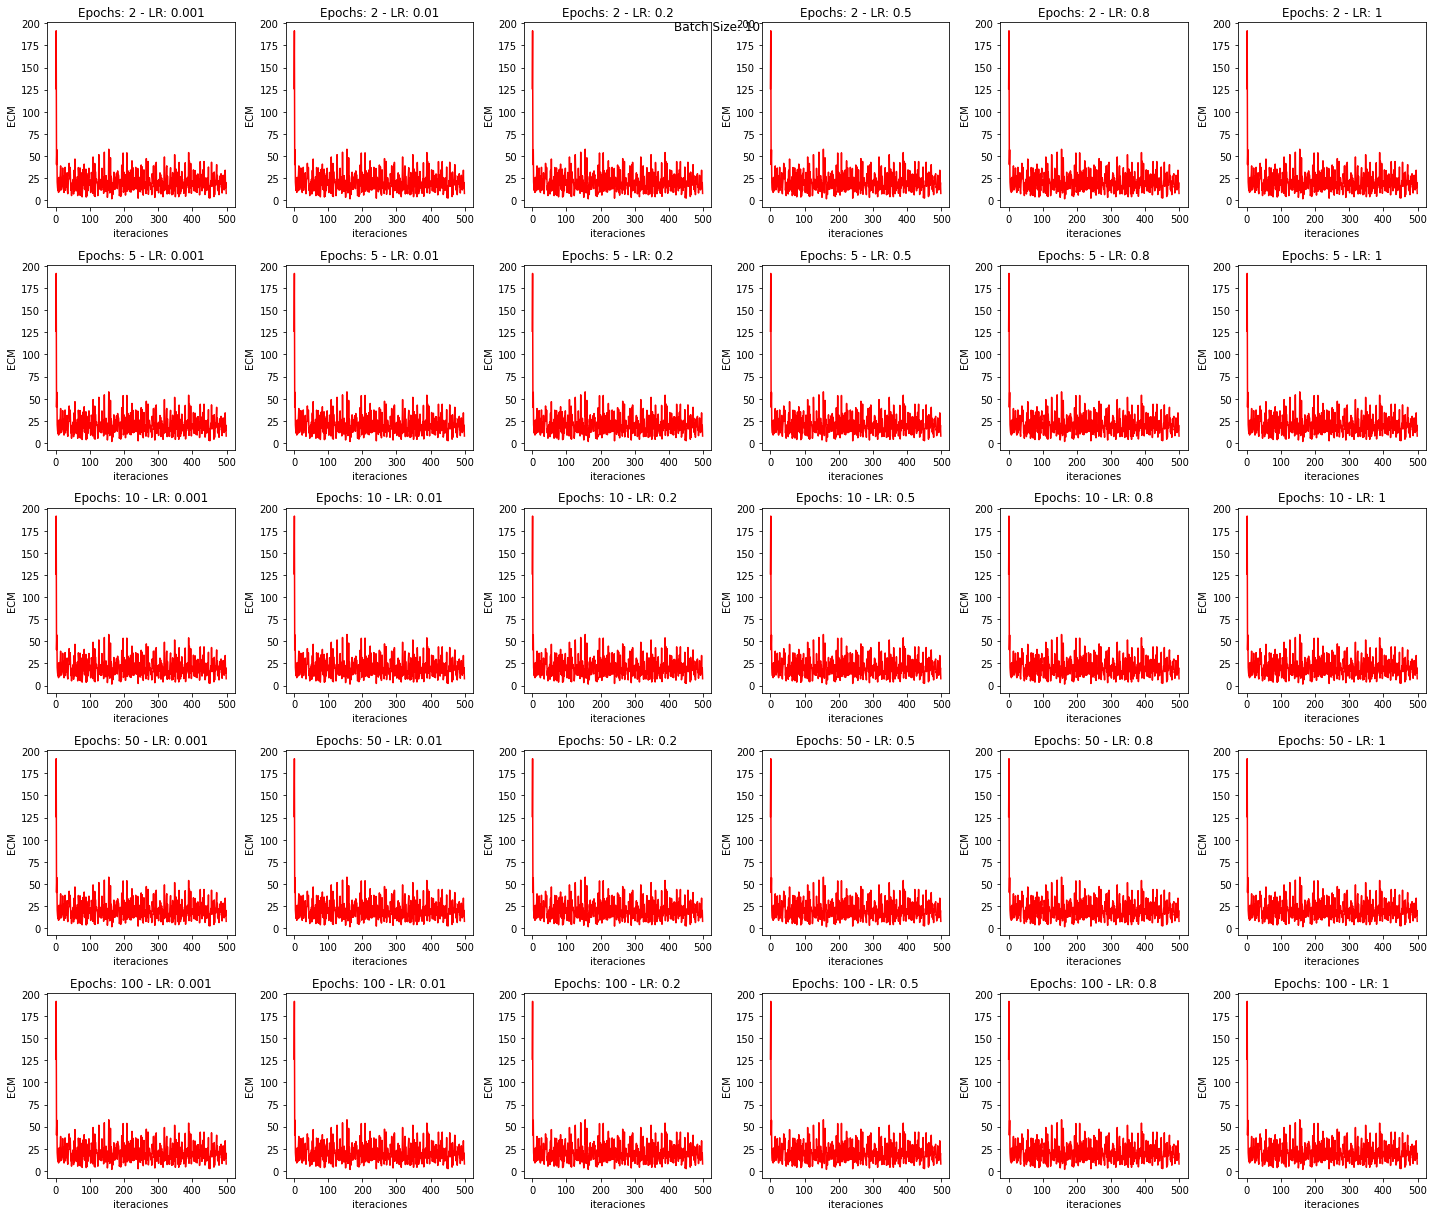

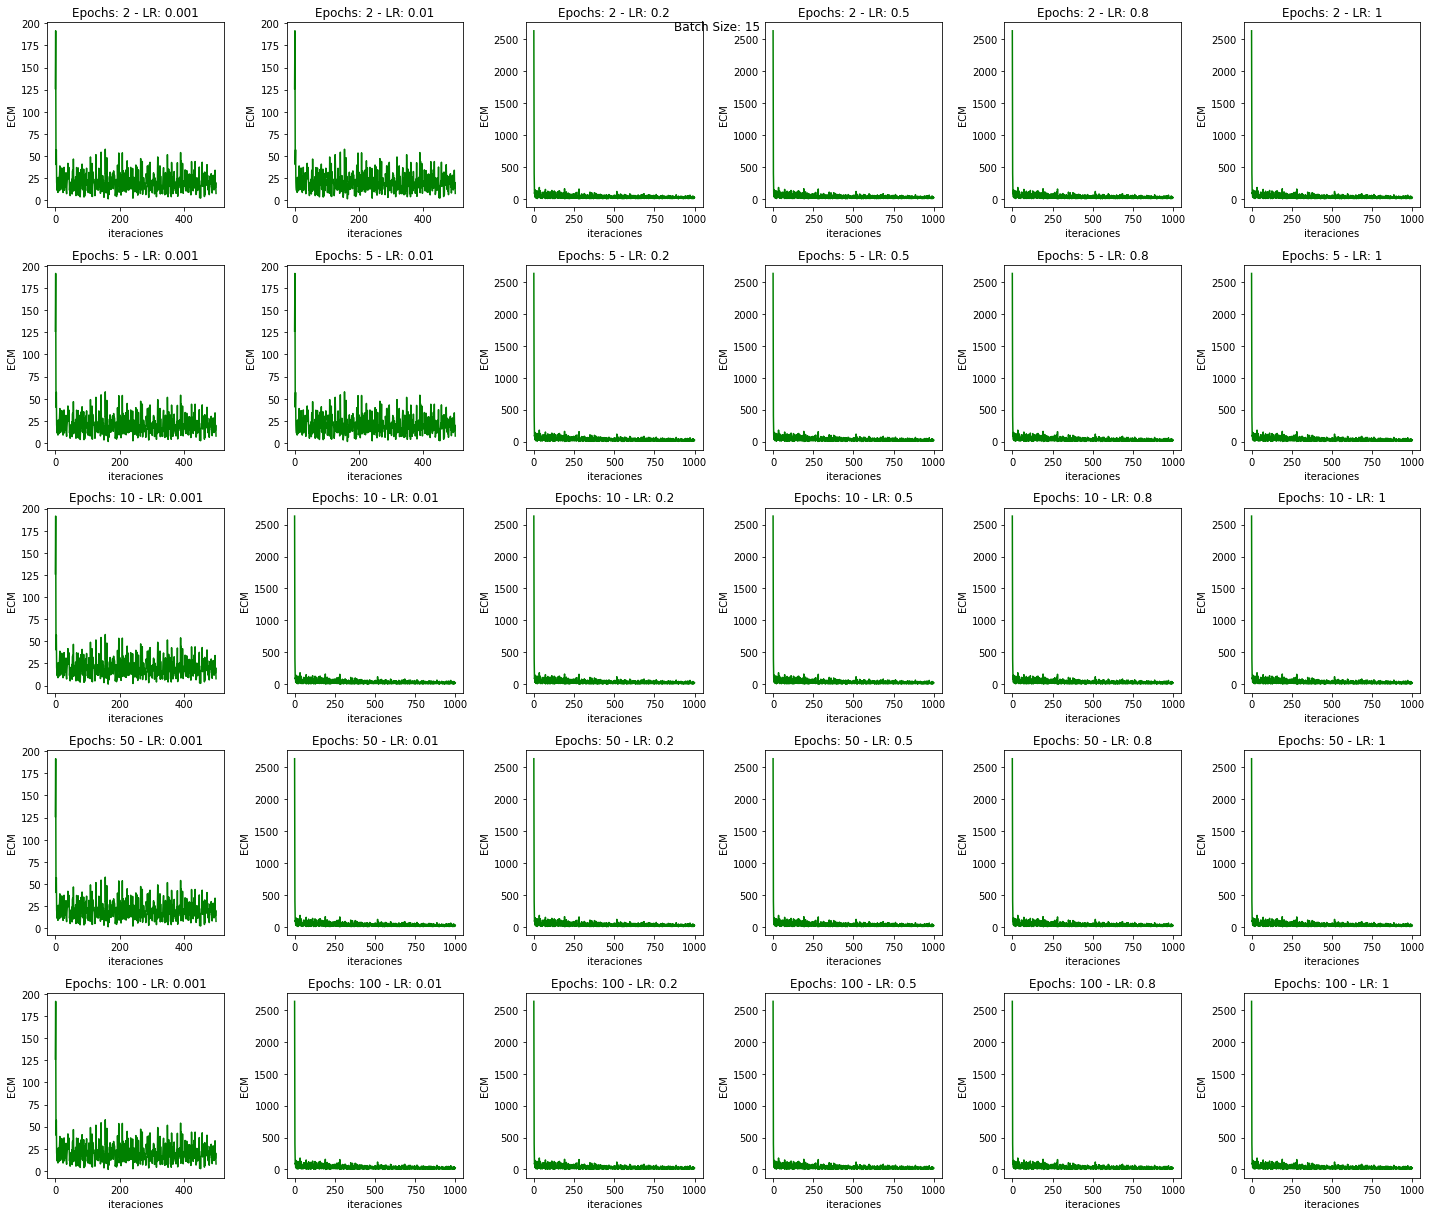

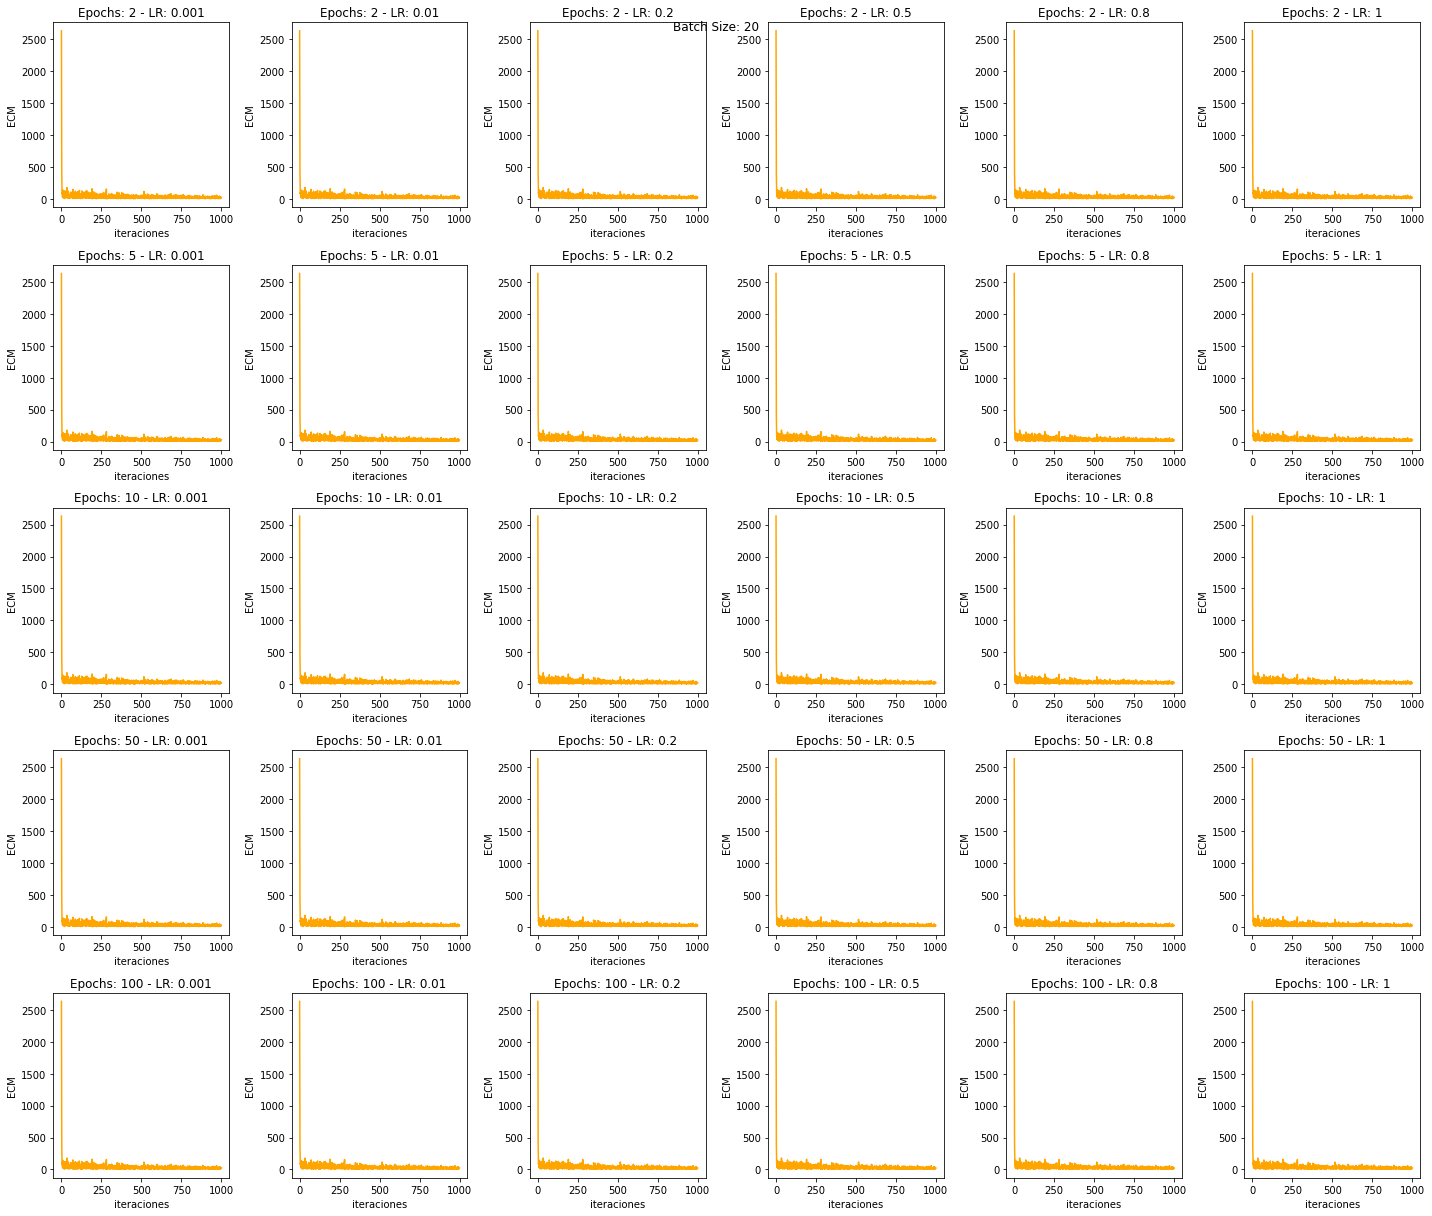

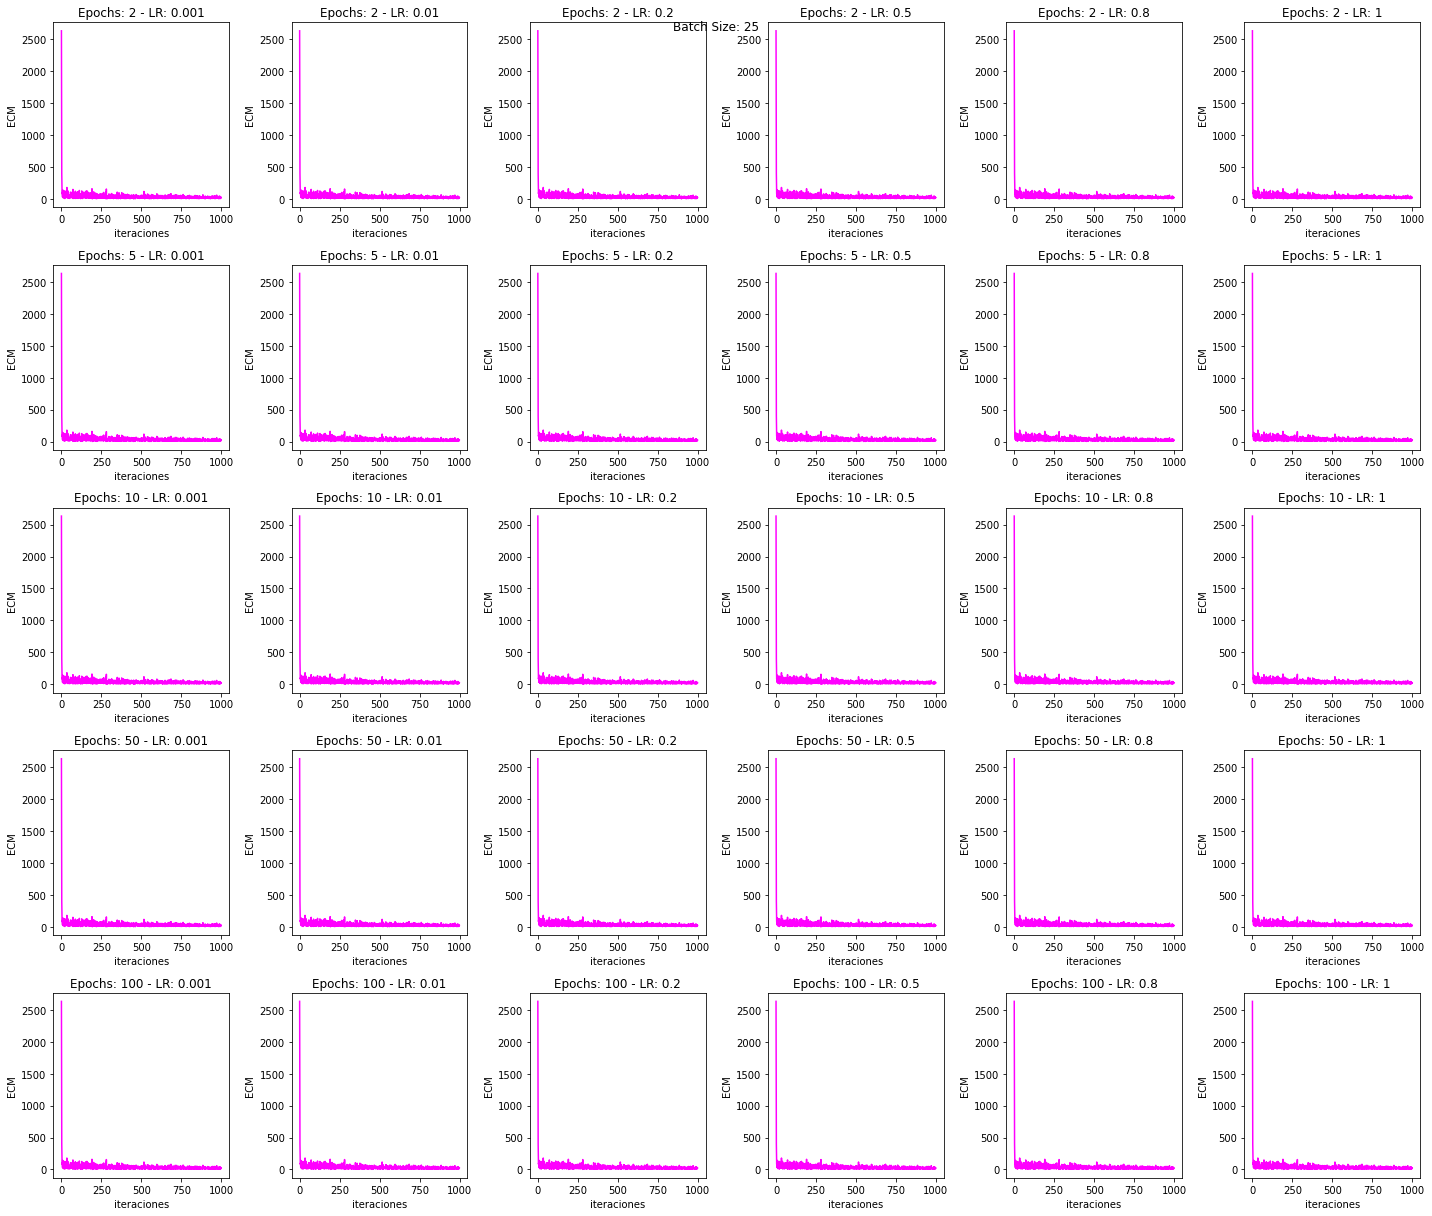

In [ ]:
colors_grph = ["blue", "red", "green", "orange", "magenta"]
cnt_lss = 0
for batch_size_i in range(len(batches)):
  fig, axs = plt.subplots(len(epochs), len(l_rates), figsize=(20,17))

  for learning_rate_i in range(len(l_rates)):
    for epoch_value_i in range(len(epochs)):
      axs[epoch_value_i][learning_rate_i].plot(high_hist[cnt_lss], color=colors_grph[batch_size_i])
      cnt_lss += 1
      axs[epoch_value_i][learning_rate_i].set_xlabel('iteraciones')
      axs[epoch_value_i][learning_rate_i].set_ylabel('ECM')
      axs[epoch_value_i][learning_rate_i].set_title('Epochs: ' + str(epochs[epoch_value_i])+ ' - LR: ' + str(l_rates[learning_rate_i]))
  fig.suptitle('Batch Size: ' + str(batches[batch_size_i]))
  fig.tight_layout()

Graficamos el desempeño con la función de nivel medio:

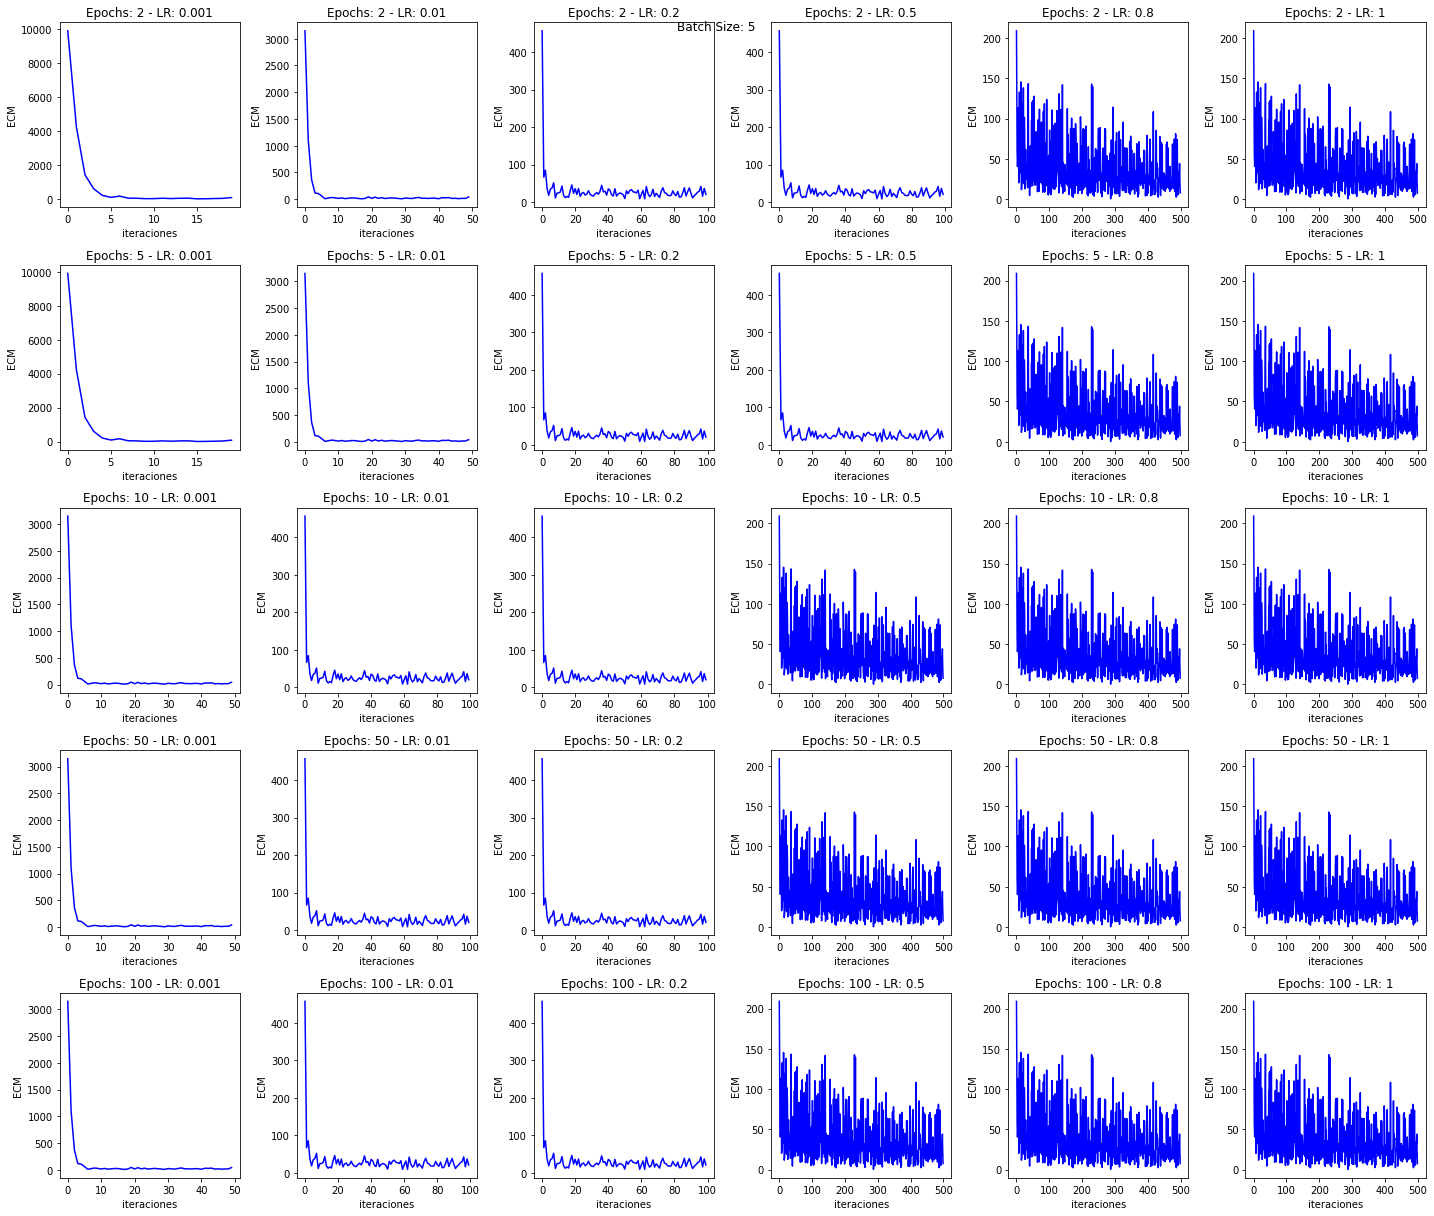

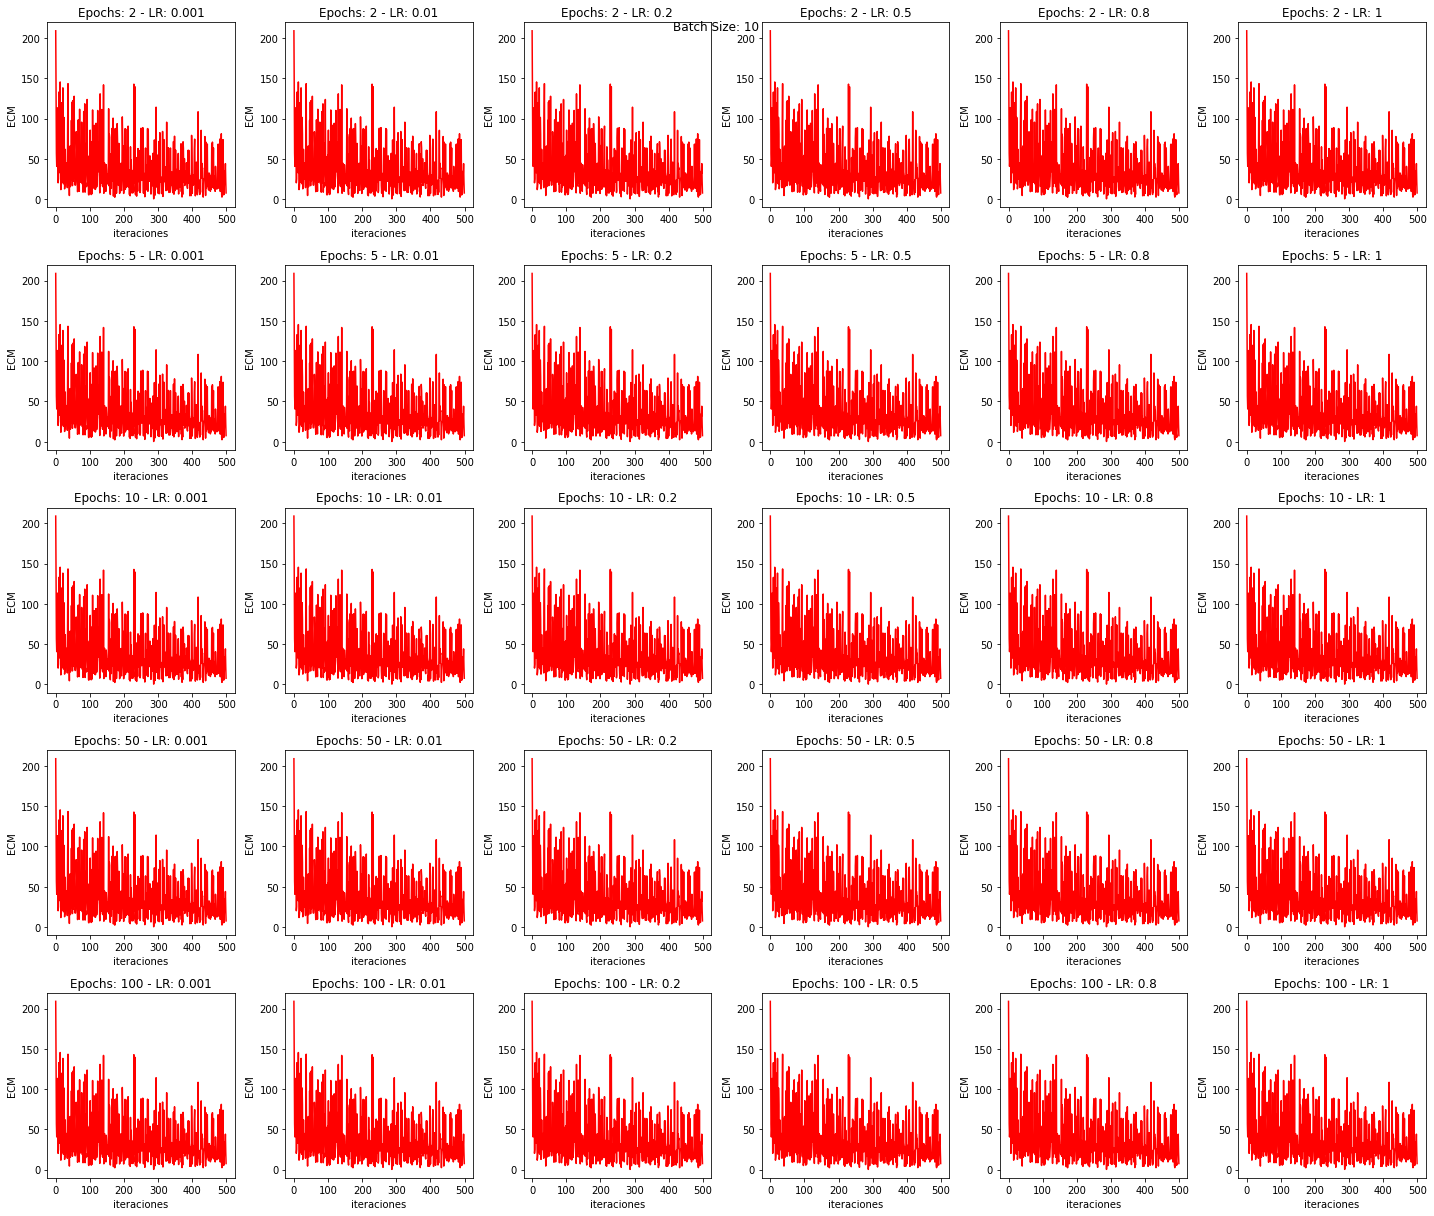

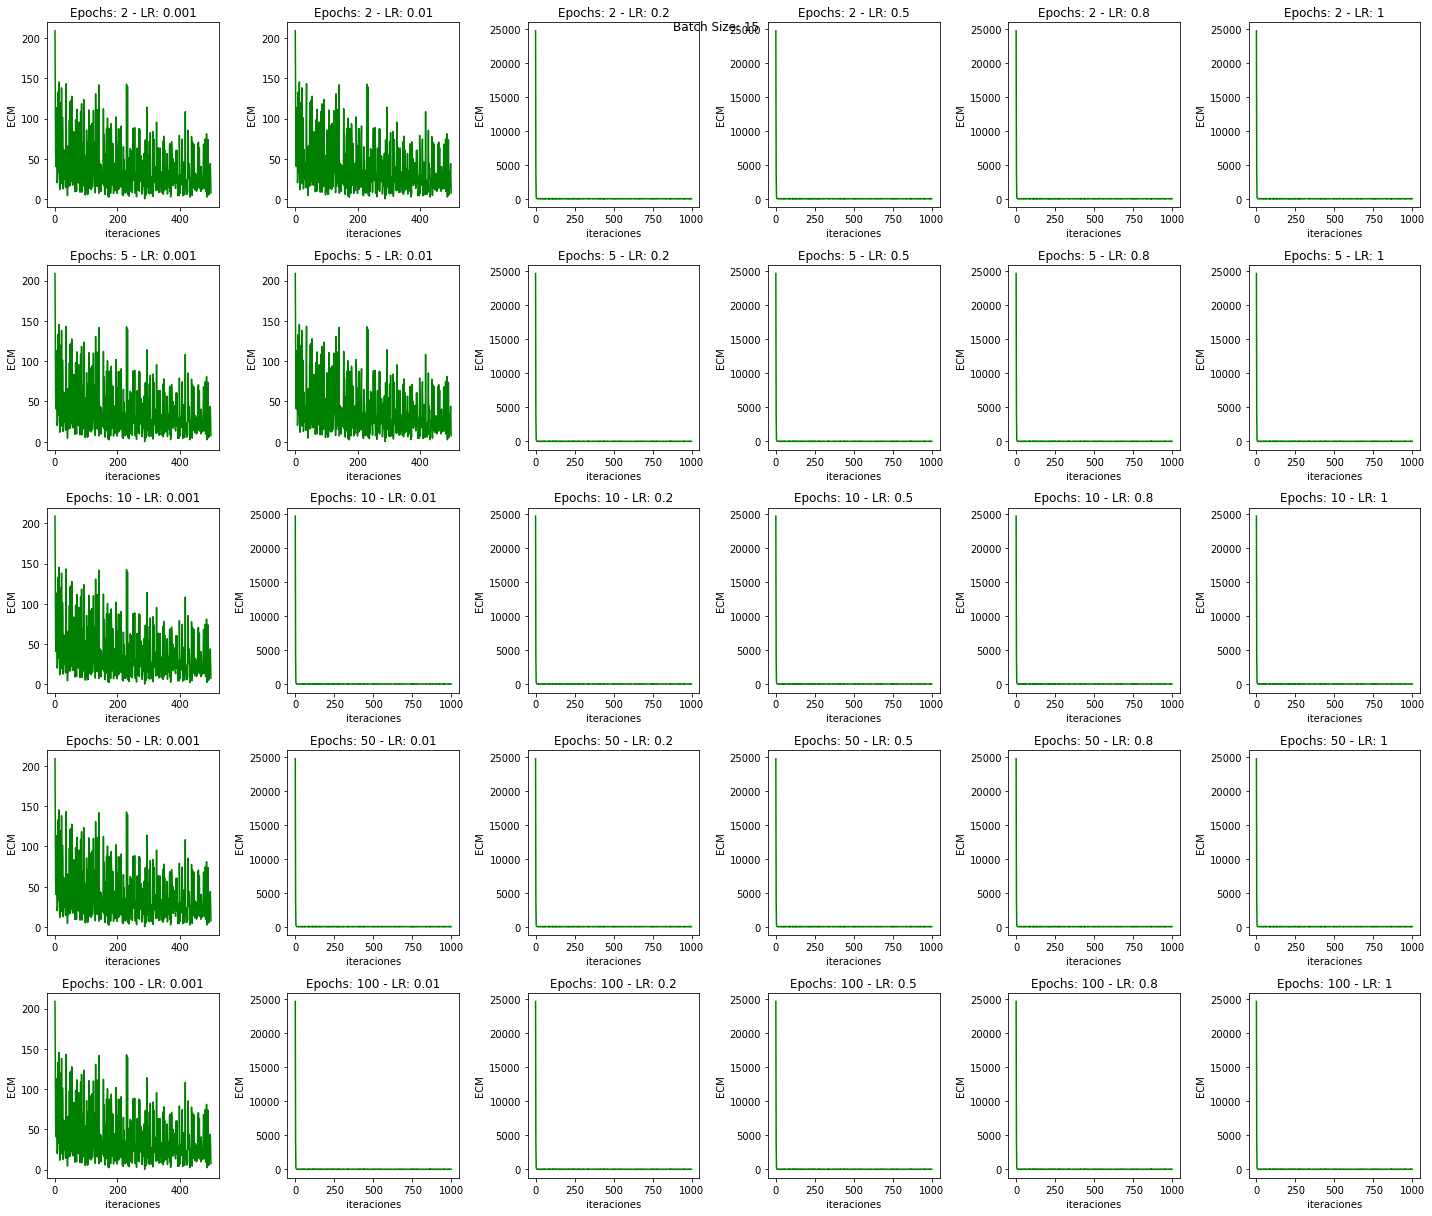

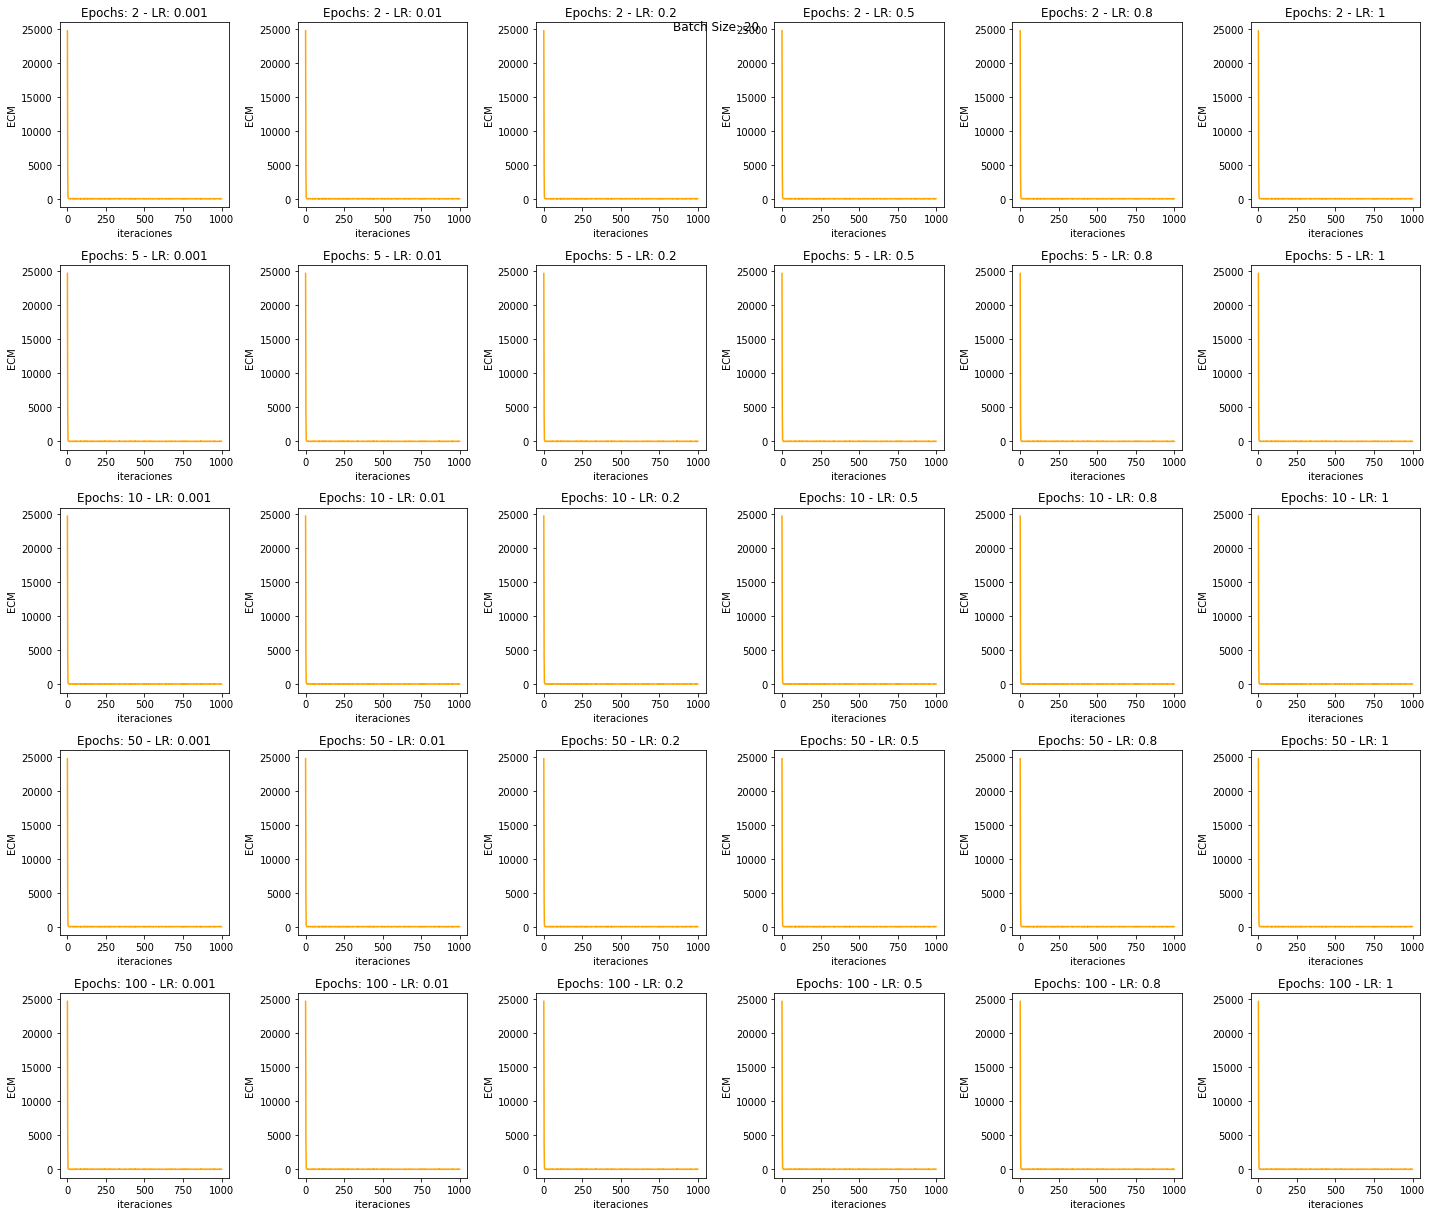

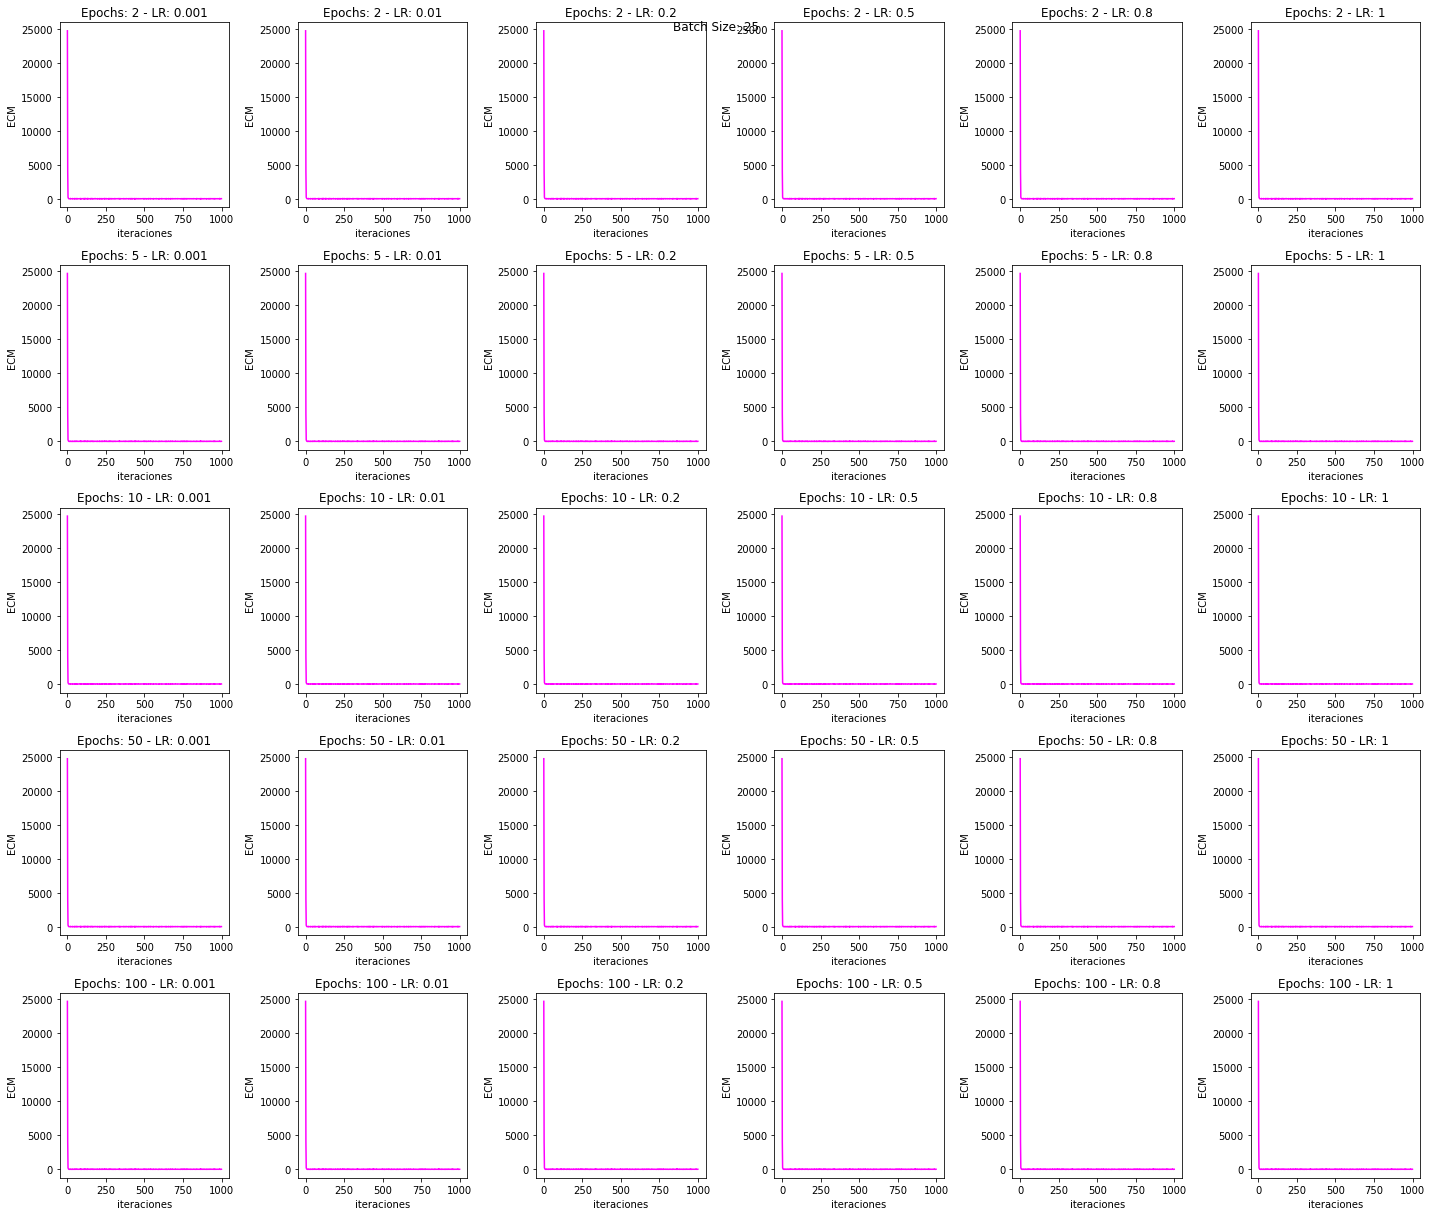

In [ ]:
colors_grph = ["blue", "red", "green", "orange", "magenta"]
cnt_lss = 0
for batch_size_i in range(len(batches)):
  fig, axs = plt.subplots(len(epochs), len(l_rates), figsize=(20,17))

  for learning_rate_i in range(len(l_rates)):
    for epoch_value_i in range(len(epochs)):
      axs[epoch_value_i][learning_rate_i].plot(mid_hist[cnt_lss], color=colors_grph[batch_size_i])
      cnt_lss += 1
      axs[epoch_value_i][learning_rate_i].set_xlabel('iteraciones')
      axs[epoch_value_i][learning_rate_i].set_ylabel('ECM')
      axs[epoch_value_i][learning_rate_i].set_title('Epochs: ' + str(epochs[epoch_value_i])+ ' - LR: ' + str(l_rates[learning_rate_i]))
  fig.suptitle('Batch Size: ' + str(batches[batch_size_i]))
  fig.tight_layout()

Probamos ambos modelos con parámetros fijos para hacer inferencia y ver diferencias. Primero, probamos con una configuración que sea buena para el modelo de alto nivel y mala para el modelo de nivel medio.

In [ ]:

b_size = 2
l_rate = 0.001
epochs = 10


# probamos el modelo de alto nivel

ds = CalifDS(x_trn, y_trn, z_trn)
trn_dl = DataLoader(ds, batch_size=b_size, shuffle=True)

# redefinimos

model_high = nn.Sequential(
  nn.Linear(2, 1)
)

opt = optim.SGD(model_high.parameters(), lr=l_rate)

# entrenamos

for _ in range(epochs):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model_high(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

x_test = torch.tensor([[3., 12.]])

with torch.no_grad():
  y_pred = model_high(x_test).numpy()

[w, b] = model_high.parameters()
print([w,b])
print("Prediccion: ", y_pred[0][0])

[Parameter containing:
tensor([[-0.0939,  0.6715]], requires_grad=True), Parameter containing:
tensor([-0.0436], requires_grad=True)]
Prediccion:  7.732397


In [ ]:
# probamos el modelo de nivel medio

ds = CalifDS(x_trn, y_trn, z_trn)
trn_dl = DataLoader(ds, batch_size=b_size, shuffle=True)

# redefinimos

model_mid = RegLin()

opt = optim.SGD(model_mid.parameters(), lr=l_rate)

# entrenamos

for _ in range(epochs):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model_mid(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

x_test = torch.tensor([[3., 12.]])

with torch.no_grad():
  y_pred = model_mid(x_test).numpy()

[w, b] = model_mid.parameters()
print([w,b])
print("Prediccion: ", y_pred[0][0])

[Parameter containing:
tensor([[-0.0832,  0.6143]], requires_grad=True), Parameter containing:
tensor([0.4433], requires_grad=True)]
Prediccion:  7.565402


Ahora probaremos con una configuración que sea buena para ambos modelos:

In [ ]:
b_size = 5
l_rate = 0.001
epochs = 2


# probamos el modelo de alto nivel

ds = CalifDS(x_trn, y_trn, z_trn)
trn_dl = DataLoader(ds, batch_size=b_size, shuffle=True)

# redefinimos

model_high = nn.Sequential(
  nn.Linear(2, 1)
)

opt = optim.SGD(model_high.parameters(), lr=l_rate)

# entrenamos

for _ in range(epochs):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model_high(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

x_test = torch.tensor([[3., 12.]])

with torch.no_grad():
  y_pred = model_high(x_test).numpy()

[w, b] = model_high.parameters()
print([w,b])
print("Prediccion: ", y_pred[0][0])

[Parameter containing:
tensor([[0.6122, 0.2140]], requires_grad=True), Parameter containing:
tensor([0.5755], requires_grad=True)]
Prediccion:  4.979401


In [ ]:
# probamos el modelo de nivel medio

ds = CalifDS(x_trn, y_trn, z_trn)
trn_dl = DataLoader(ds, batch_size=b_size, shuffle=True)

# redefinimos

model_mid = RegLin()

opt = optim.SGD(model_mid.parameters(), lr=l_rate)

# entrenamos

for _ in range(epochs):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model_mid(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

x_test = torch.tensor([[3., 12.]])

with torch.no_grad():
  y_pred = model_mid(x_test).numpy()

[w, b] = model_mid.parameters()
print([w,b])
print("Prediccion: ", y_pred[0][0])

[Parameter containing:
tensor([[0.5657, 0.3004]], requires_grad=True), Parameter containing:
tensor([-0.1593], requires_grad=True)]
Prediccion:  5.142017


**Discusión**

Se hicieron dos pruebas: una con parámetros para los que el desempeño fue diferente para ambos modelos y otra en la que el desempeño fue similar. En ambos casos observamos que las predicciones son consistentes: 8.20 y 8.71 para el modelo de alto nivel, 7.65 y 7.04 para el modelo de nivel medio respectivamente.


En general para el caso del modelo de nivel medio es posible ver cómo un número mayor de épocas hace que el desempeño de la optimización sea mayor, al contrario que con el modelo de alto nivel, el cual presenta más ruido conforme va aumentando el número de épocas. Sin embargo, el nivel de ruido es significativamente menor en el modelo de alto nivel. En el caso particular del modelo de alto nivel es posible observar que las tasas de aprendizaje hacen que el ruido aumente conforme se acercan a 1. En resumen, el modelo de alto nivel parece ser más sensible a los cambios en la tasa de aprendizaje y el modelo de nivel medio a los cambios en épocas.


# 4. Red completamente conectada con PyTorch

Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguientes especificaciones:

* Explora con diferentes números de neuronas, capas, funciones de activación e hiperparámetros

* Discute tus resultados con las distintas configuraciones

Descargamos el conjunto de datos y obtenemos los parámetros para normalizar más adelante:

In [ ]:
# directorio de datos
DATA_DIR = './data'
# objeto para normalizacion de las imagenes
transform = trans.Compose([
    trans.ToTensor()
])

train_transform_meanstd = trans.Compose([trans.ToTensor()])

# obtenemos el conjunto de entrenamiento normalizándolo como tensor
train_set_meanstd = FashionMNIST(
    root=DATA_DIR, 
    train=True, 
    download=True, 
    transform=train_transform_meanstd
  )

# obtenemos la media y desviacion estandar
MEAN = train_set_meanstd.train_data.float().mean()/255.0
MEAN = (MEAN.item(),)
STD = train_set_meanstd.train_data.float().std()/255.0
STD = (STD.item(),)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Probaremos la arquitectura de la red con los siguientes parámetros:

In [ ]:
# Tasa de aprendizaje
l_lrates = [0.01, 0.5]
# epocss
l_epochs = [5, 20, 50]
# numero de neuronas
l_neurons_values = [5, 10]
# capas ocultas
l_hidden = [2, 5]

#funciones
l_acts = [
  nn.Sigmoid(),
  nn.ReLU(),
  nn.Tanh(),
]



# tamaño del lote
BATCH_SIZE = 128

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Definiremos nuestra red neuronal modificando el constructor para recigbi el número de capas y la función de activación como parámetros:

In [ ]:
# definición del modelo
# Se recibe como parametro el número de capas ocultas,
# La capa 1 siempre tendra 128, la segunda 256, y la tercera 512
class MLP(nn.Module):
    
    # inicializador
    def __init__(self, n_hidden, activation_function_id, nvalues):
        
        # inicilización del objeto padre, obligatorio
        super(MLP, self).__init__()

        # Función de activación a utilizar
        self.activation_function_id = activation_function_id

        # Tamaño de la entrada
        self.input_size = 1 * 28 * 28
        
        # Capas ocultas
        self.n_hidden = n_hidden
        self.hidden = []
        # Primer capa oculta
        self.hidden.append(nn.Linear(self.input_size, l_neurons_values[nvalues]))
        for hidden_i in range(1, self.n_hidden):
          self.hidden.append(nn.Linear(
              self.hidden[-1].out_features,
              l_neurons_values[nvalues]
              ))

        # Capa de Salida
        self.output = nn.Linear(self.hidden[-1].out_features, 10)
    
    # metodo para inferencia
    def forward(self, x):

        # aplanamos los pixeles de la imagen
        # [N, 1, 28, 28] => [N, 1x28x28]
        x = x.view(-1, self.input_size)
       
        # inferencia
        # capas ocultas
        for hidden_i in range(self.n_hidden):
          x = self.hidden[hidden_i](x)
          x = l_acts[self.activation_function_id](x)
          # print(activation_functions_values[self.activation_function_id])
          # print(x)
        # Capa de salida
        x = self.output(x)

        return x

Definimos el dataset y el dataloader:

In [ ]:
# transformaciones para la imagen
trn_tsfm = trans.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    trans.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    trans.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = FashionMNIST(
    root=DATA_DIR,
    train=True,
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    trn_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# transformaciones para la imagen
tst_tsfm = trans.Compose([
    trans.ToTensor(),
    trans.Normalize(MEAN, STD),
])

# creamos un Dataset
tst_ds = FashionMNIST(
    root=DATA_DIR, 
    train=False,
    transform=tst_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    tst_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Haremos las pruebas con todas las diferentes funciones. Comenzamos con la función sigmoide:

In [ ]:
# Historiales de perdida
loss_hists = []
acc_hists = []


for ep in range(len(l_epochs)):


  for hid in range(len(l_hidden)):


    for rate in range(len(l_lrates)):

      for n_value in range(len(l_neurons_values)):
      
        # Definimos el modelo
        curr_model = FMLP(l_hidden[hid], 0, n_value)

        # optimizador
        opt = optim.SGD(
            curr_model.parameters(), lr=l_rates[rate])
        
        # historial de pérdida
        curr_loss_hist = []

        # ciclo de entrenamiento
        for curr_epoch_i in range(l_epochs[ep]):
      
          # entrenamiento de una época
          for x, y_true in trn_dl:

              # vaciamos los gradientes
              opt.zero_grad()
              # hacemos inferencia para obtener los logits
              y_lgts = curr_model(x)
              # calculamos la pérdida
              loss = F.cross_entropy(y_lgts, y_true)
              # retropropagamos
              loss.backward()
              # actulizamos parámetros
              opt.step()

              # agregamos al historial de pérdidas
              curr_loss_hist.append(loss.item())

        loss_hists.append(curr_loss_hist)

   
        # modelo en modo de evaluación
        curr_model.eval()

        with torch.no_grad(): 
                
            accs = []
            # validación de la época
            for x, y_true in take(tst_dl,10):
                # hacemos inferencia para obtener los logits
                y_lgts = curr_model(x)
                # calculamos las probabilidades
                y_prob = F.softmax(y_lgts, 1)
                # obtenemos la clase predicha
                y_pred = torch.argmax(y_prob, 1)
                
                # calculamos la exactitud
                acc = (y_true == y_pred).type(torch.float32).mean()

                accs.append(acc.item() * 100)

            acc = np.mean(accs)
            acc_hists.append(acc)


        print(f"SIG - EP: {l_epochs[ep]} HIDDEN: {l_hidden[hid]} LR: {l_rates[rate]}")
        plt.plot(curr_loss_hist, color='red')
        plt.xlabel('época')
        plt.ylabel('pérdida')
        plt.show()

KeyboardInterrupt: ignored

En el caso de la función sigmoide vemos cómo la evolución tiende a reducir la pérdida. Sin embargo para ciertas épocas parece retroceder en la exactitud del desempeño. Esto podría deberse a la característica del desvanecimiento de gradiente de esta función.

Continuamos con la función ReLU:

In [ ]:
# Historiales de perdida
loss_hists = []
acc_hists = []


for ep in range(len(l_epochs)):


  for hid in range(len(l_hidden)):


    for rate in range(len(l_lrates)):

      for n_value in range(len(l_neurons_values)):
      
        # Definimos el modelo
        curr_model = FMLP(l_hidden[hid], 1, n_value)

        # optimizador
        opt = optim.SGD(
            curr_model.parameters(), lr=l_rates[rate])
        
        # historial de pérdida
        curr_loss_hist = []

        # ciclo de entrenamiento
        for curr_epoch_i in range(l_epochs[ep]):
      
          # entrenamiento de una época
          for x, y_true in trn_dl:

              # vaciamos los gradientes
              opt.zero_grad()
              # hacemos inferencia para obtener los logits
              y_lgts = curr_model(x)
              # calculamos la pérdida
              loss = F.cross_entropy(y_lgts, y_true)
              # retropropagamos
              loss.backward()
              # actulizamos parámetros
              opt.step()

              # agregamos al historial de pérdidas
              curr_loss_hist.append(loss.item())

        # save the current list of losses 
        loss_hists.append(curr_loss_hist)

     
        # modelo en modo de evaluación
        curr_model.eval()

        # evitamos que se registren las operaciones 
        # en la gráfica de cómputo
        with torch.no_grad(): 
                
            accs = []
            # validación de la época
            for x, y_true in take(tst_dl,10):
                # hacemos inferencia para obtener los logits
                y_lgts = curr_model(x)
                # calculamos las probabilidades
                y_prob = F.softmax(y_lgts, 1)
                # obtenemos la clase predicha
                y_pred = torch.argmax(y_prob, 1)
                
                # calculamos la exactitud
                acc = (y_true == y_pred).type(torch.float32).mean()

                accs.append(acc.item() * 100)

            acc = np.mean(accs)
            acc_hists.append(acc)

        # Print progress
        print(f"ReLU - EP: {l_epochs[ep]} HIDDEN: {l_hidden[hid} LR: {l_rates[rate]}")
        plt.plot(curr_loss_hist, color='red')
        plt.xlabel('época')
        plt.ylabel('pérdida')
        plt.show()
        print(acc_hists[-1])

KeyboardInterrupt: ignored

En el caso de la función ReLU es posible ver cómo tasas de aprendizaje más cercanas a 0.1 hacen que la función tenga mejor desempeño, al contrario de usar una tasa de 0.001 en la que es posible ver un desempeño muy bajo. A su vez, el número de neuronas en las capas ocultas tiene un efecto positivo conforme aumenta. Sin embargo, se observa el mejor desempeño con 5 épocas y 5 neuronas por capa oculta.

Finalizamos con la función tangente hiperbólica:

ReLU - EP: 5 HIDDEN: 2 LR: 0.001


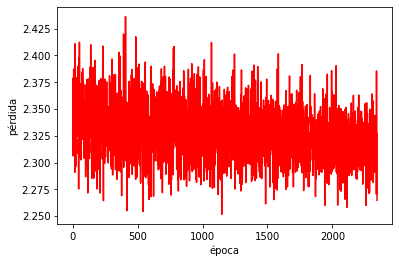

12.5
ReLU - EP: 5 HIDDEN: 2 LR: 0.001


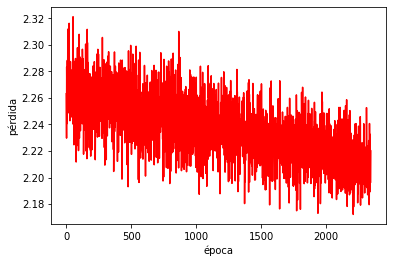

20.625
ReLU - EP: 5 HIDDEN: 2 LR: 0.01


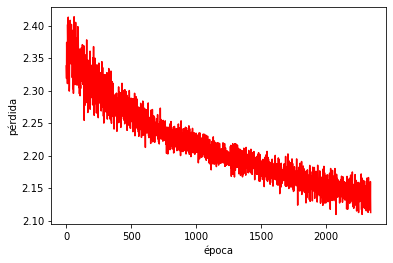

30.546875
ReLU - EP: 5 HIDDEN: 2 LR: 0.01


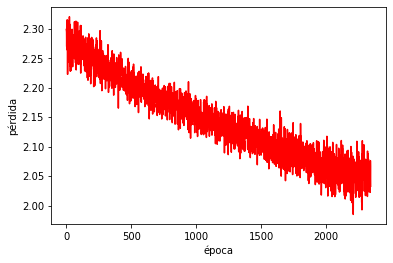

40.703125
ReLU - EP: 5 HIDDEN: 5 LR: 0.001


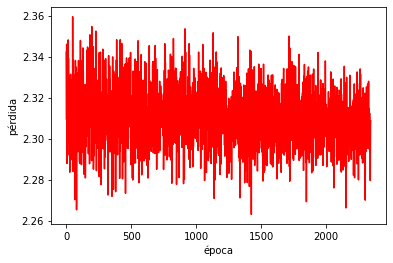

10.078125
ReLU - EP: 5 HIDDEN: 5 LR: 0.001


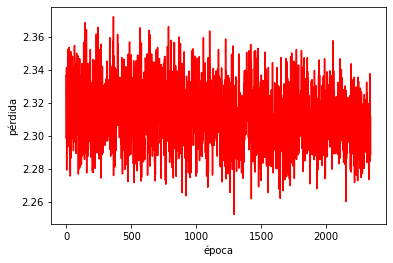

15.0
ReLU - EP: 5 HIDDEN: 5 LR: 0.01


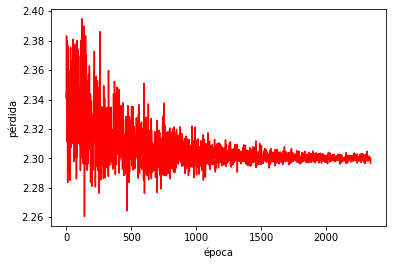

10.546875
ReLU - EP: 5 HIDDEN: 5 LR: 0.01


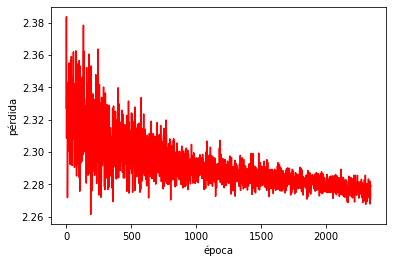

21.328125
ReLU - EP: 20 HIDDEN: 2 LR: 0.001


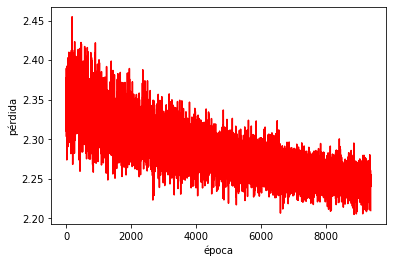

19.21875
ReLU - EP: 20 HIDDEN: 2 LR: 0.001


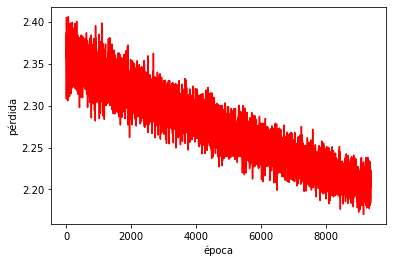

22.96875
ReLU - EP: 20 HIDDEN: 2 LR: 0.01


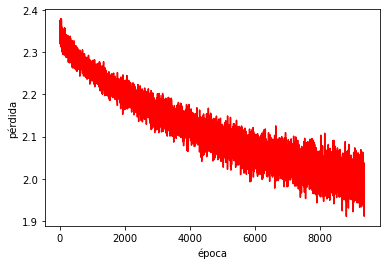

34.140625
ReLU - EP: 20 HIDDEN: 2 LR: 0.01


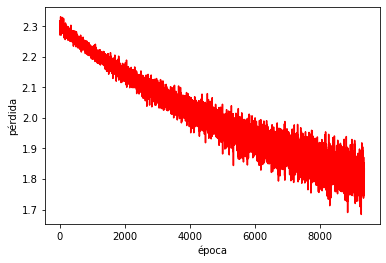

45.46875
ReLU - EP: 20 HIDDEN: 5 LR: 0.001


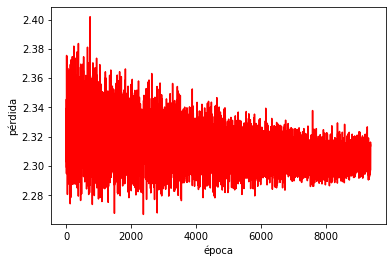

7.8125
ReLU - EP: 20 HIDDEN: 5 LR: 0.001


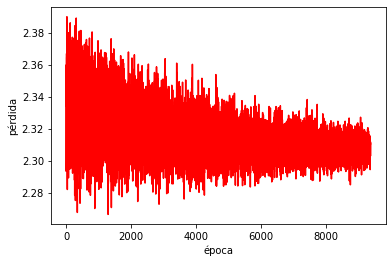

5.46875
ReLU - EP: 20 HIDDEN: 5 LR: 0.01


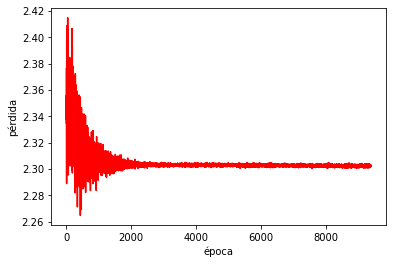

8.90625
ReLU - EP: 20 HIDDEN: 5 LR: 0.01


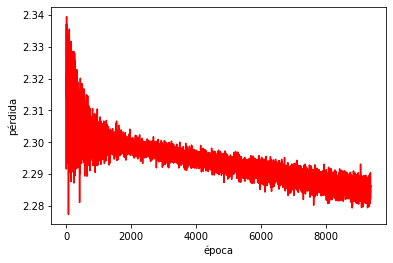

24.296875
ReLU - EP: 50 HIDDEN: 2 LR: 0.001


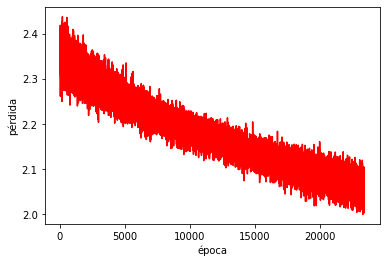

29.21875
ReLU - EP: 50 HIDDEN: 2 LR: 0.001


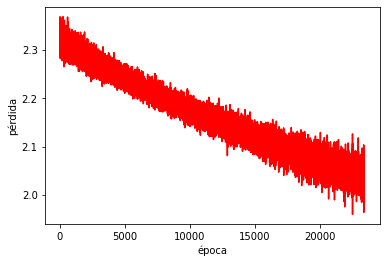

41.5625
ReLU - EP: 50 HIDDEN: 2 LR: 0.01


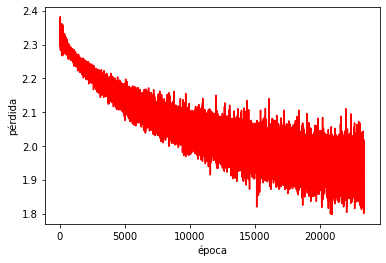

36.25
ReLU - EP: 50 HIDDEN: 2 LR: 0.01


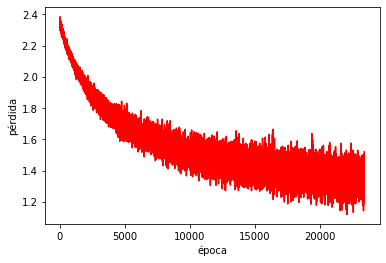

56.40625
ReLU - EP: 50 HIDDEN: 5 LR: 0.001


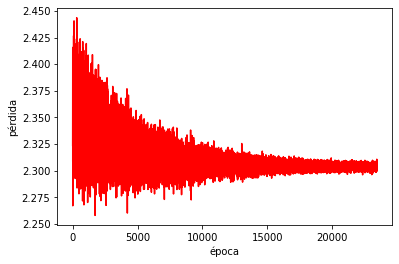

8.828125


KeyboardInterrupt: ignored

In [ ]:
# Historiales de perdida
loss_hists = []
acc_hists = []


for ep in range(len(l_epochs)):


  for hid in range(len(l_hidden)):

    for rate in range(len(l_lrates)):

      for n_value in range(len(l_neurons_values)):
      
        # Definimos el modelo
        curr_model = FMLP(l_hidden[hid], 2, n_value)

        # optimizador
        opt = optim.SGD(
            curr_model.parameters(), lr=l_rates[rate])
        
        # historial de pérdida
        curr_loss_hist = []

        # ciclo de entrenamiento
        for curr_epoch_i in range(l_epochs[ep]):
      
          # entrenamiento de una época
          for x, y_true in trn_dl:

              # vaciamos los gradientes
              opt.zero_grad()
              # hacemos inferencia para obtener los logits
              y_lgts = curr_model(x)
              # calculamos la pérdida
              loss = F.cross_entropy(y_lgts, y_true)
              # retropropagamos
              loss.backward()
              # actulizamos parámetros
              opt.step()

              # agregamos al historial de pérdidas
              curr_loss_hist.append(loss.item())

        # save the current list of losses 
        loss_hists.append(curr_loss_hist)

       
        # modelo en modo de evaluación
        curr_model.eval()

        # evitamos que se registren las operaciones 
        # en la gráfica de cómputo
        with torch.no_grad(): 
                
            accs = []
            # validación de la época
            for x, y_true in take(tst_dl,10):
                # hacemos inferencia para obtener los logits
                y_lgts = curr_model(x)
                # calculamos las probabilidades
                y_prob = F.softmax(y_lgts, 1)
                # obtenemos la clase predicha
                y_pred = torch.argmax(y_prob, 1)
                
                # calculamos la exactitud
                acc = (y_true == y_pred).type(torch.float32).mean()

                accs.append(acc.item() * 100)

            acc = np.mean(accs)
            acc_hists.append(acc)

        # Print progress
        print(f"TanH - EP: {l_epochs[ep]} HIDDEN: {l_hidden[hid]} LR: {l_rates[rate]}")
        plt.plot(curr_loss_hist, color='red')
        plt.xlabel('época')
        plt.ylabel('pérdida')
        plt.show()

En el caso de la función de tangente hiperbólica podemos apreciar que, a comparación de la función sigmoide, existe una tendencia clara a reducir el valor de la pérdida en las diferentes iteraciones. Si bien esta función también presenta desvanecimiento de gradiente, el rango en el que acota los valores la hace más flexible y es posible apreciarlo en el desempeño con este problema.

**Conclusiones**

En general es posible apreciar que las tres funciones tienen diferentes combinacines de parámentros en las que se comportan mejor. Algo apreciable en los tres casos es que tienen a estabilizarse en valores de pérdida significativamente lejanos del 0. Se recomienda buscar configuraciones diferentes a las utilizadas en este ejercicio para hacer un análisis más extensivo. 